In [ ]:
!apt-get install openjdk-8-jdk-headless

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 36.5 MB/36.5 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 openjdk-8-jre-headless amd64 8u362-ga-0ubuntu1~20.04.1 [28.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 openjdk-8-jdk-headless amd64 8u362-ga-0ubuntu1~20.04.1 [8,282 kB]
Fetched 8,945 kB in 48s (187 kB/s)
Selecting previously unselected package libxtst6:amd64.
(Rea

In [ ]:
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz

--2023-05-15 13:40:55--  https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272637746 (260M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop2.7.tgz’

spark-3.2.1-bin-had 100%[===================>] 260.01M  2.19MB/s    in 3m 6s   

2023-05-15 13:44:11 (1.40 MB/s) - ‘spark-3.2.1-bin-hadoop2.7.tgz’ saved [272637746/272637746]



In [ ]:
!tar xf spark-3.2.1-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"


In [ ]:
import findspark
findspark.init()
findspark.find()

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("DataCleaningApp")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
spark

Classification

In [ ]:
combined_df = spark.read.format("csv").option("header", "true").load("/content/sample_data/combined-data.csv")

combined_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- userSessionId: string (nullable = true)
 |-- teamLevel: string (nullable = true)
 |-- platformType: string (nullable = true)
 |-- count_gameclicks: string (nullable = true)
 |-- count_hits: string (nullable = true)
 |-- count_buyId: string (nullable = true)
 |-- avg_price: string (nullable = true)



In [ ]:
#drop rows with null values 
combined_df.dropna()

In [ ]:
import pandas as pd
from pyspark.sql.functions import when , col ,count
from pyspark.ml.feature import StringIndexer

# Create an indexer
indexer = StringIndexer(inputCol='platformType', outputCol='Platform_idx')

# Indexer identifies categories in the data
indexer_model = indexer.fit(combined_df)

# Indexer creates a new column with numeric index values
combined_indexed = indexer_model.transform(combined_df)

# Add a spender column
combined_indexed = combined_indexed.withColumn('label', when((col('avg_price') >= 6), 1).otherwise(0))

combined_indexed.show()
print(combined_indexed.count())

+------+-------------+---------+------------+----------------+----------+-----------+---------+------------+-----+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|Platform_idx|label|
+------+-------------+---------+------------+----------------+----------+-----------+---------+------------+-----+
|   937|         5652|        1|     android|              39|         0|          1|        1|         1.0|    0|
|  1652|         5706|        1|     android|              46|         7|          1|        1|         1.0|    0|
|  2306|         5783|        1|     android|              67|         5|          1|        1|         1.0|    0|
|   649|         5811|        1|       linux|              51|         9|          1|        1|         3.0|    0|
|  1821|         5914|        1|     windows|             178|        22|          1|        1|         2.0|    0|
|   518|         5921|        1|       linux|             121|        16|       

In [ ]:
from pyspark.ml.feature import VectorAssembler


combined_indexed = combined_indexed.withColumn('teamLevel', col('teamLevel').cast('float'))
combined_indexed = combined_indexed.withColumn('count_hits', col('count_hits').cast('float'))

# Create an assembler object
assembler = VectorAssembler(inputCols=[
    'teamLevel', 'count_hits', 'Platform_idx'
], outputCol='features')

# Consolidate predictor columns
combined_assembled = assembler.transform(combined_indexed)

# Check the resulting column
combined_assembled.select('features', 'label').show(5, truncate=False)

+--------------+-----+
|features      |label|
+--------------+-----+
|[1.0,0.0,1.0] |0    |
|[1.0,7.0,1.0] |0    |
|[1.0,5.0,1.0] |0    |
|[1.0,9.0,3.0] |0    |
|[1.0,22.0,2.0]|0    |
+--------------+-----+
only showing top 5 rows



In [ ]:
# Split into training and test sets in a 80:20 ratio
combined_train, combined_test = combined_assembled.randomSplit([0.8, 0.2], seed=17)

# Check that training set has around 80% of records
training_ratio = combined_train.count() / combined_assembled.count()
print(training_ratio)

0.8015591778880227


In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

# Create a classifier object and fit to the training data
tree = DecisionTreeClassifier()
tree_model = tree.fit(combined_train)

# Create predictions for the testing data and take a look at the predictions
prediction = tree_model.transform(combined_test)
prediction.select('label', 'prediction', 'probability').show(5, False)

+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0    |0.0       |[0.8690476190476191,0.13095238095238096]|
|0    |0.0       |[0.957983193277311,0.04201680672268908] |
|1    |1.0       |[0.18181818181818182,0.8181818181818182]|
|0    |0.0       |[0.957983193277311,0.04201680672268908] |
|0    |0.0       |[0.957983193277311,0.04201680672268908] |
+-----+----------+----------------------------------------+
only showing top 5 rows



In [ ]:
# Create a confusion matrix
prediction.groupBy('label', 'prediction').count().show(),col

# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label = 1').count()
FP = prediction.filter('prediction = 1 AND label = 0').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN + TP) / (TN + TP + FN + FP)
print(accuracy)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   15|
|    0|       0.0|  148|
|    1|       1.0|  103|
|    0|       1.0|   14|
+-----+----------+-----+

0.8964285714285715


Clustering

In [ ]:
from pyspark.sql.functions import isnan, count, when

combined_data = spark.read.format("csv").option("header", "true").load("/content/sample_data/combined-data.csv")

# Define the input columns to be used as features
num_cols = ['count_gameclicks', 'count_hits', 'avg_price']

combined_data.select([count(when(isnan(c), c)).alias(c) for c in num_cols]).show()


combined_data = combined_data.withColumn('count_gameclicks', col('count_gameclicks').cast('float'))
combined_data = combined_data.withColumn('count_hits', col('count_hits').cast('float'))
combined_data = combined_data.withColumn('avg_price', col('avg_price').cast('float'))


+----------------+----------+---------+
|count_gameclicks|count_hits|avg_price|
+----------------+----------+---------+
|               0|         0|        0|
+----------------+----------+---------+



In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

# set up each processing step with the correct input columns and output
assemble=VectorAssembler(inputCols=num_cols, outputCol='features')
scale=StandardScaler(inputCol='features',outputCol='standardized')
km = KMeans(featuresCol = 'standardized')

# assemble the pipeline 
pipe = Pipeline(stages=[assemble, scale, km])

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

# set up evaluator 
evaluator = ClusteringEvaluator()

# test between k=2 and 10 
for k in range(2,10):
  # set the KMeans stage of the pipe to hold each value of K and the random seed = 1 and fit that pipe to data  
  kmeans = pipe.getStages()[-1].setK(k).setSeed(1)  
  model = pipe.fit(combined_data)
  
  # build a preds dataset of each k value
  preds = model.transform(combined_data)

  # silhouette score each prediction set and print formatted output 
  silhouette = evaluator.evaluate(preds)
  print(f'Tested: {k} clusters: {silhouette}')

Tested: 2 clusters: 0.8791124447842833
Tested: 3 clusters: 0.113445155235832
Tested: 4 clusters: 0.1642552731620225
Tested: 5 clusters: 0.20496743475303306
Tested: 6 clusters: 0.11513601665627916
Tested: 7 clusters: 0.14447690094634036
Tested: 8 clusters: 0.09146370985833763
Tested: 9 clusters: 0.05504250256365447


In [ ]:
pipe.getStages()[-1].setK(2).setSeed(1)  # set the random seed for the algorithm and the value for k

# fit model and transform the data
model = pipe.fit(combined_data)
clusters = model.transform(combined_data)
clusters.show()

centers = model.stages[-1].clusterCenters()
print(centers)


+------+-------------+---------+------------+----------------+----------+-----------+---------+----------------+--------------------+----------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|        features|        standardized|prediction|
+------+-------------+---------+------------+----------------+----------+-----------+---------+----------------+--------------------+----------+
|   937|         5652|        1|     android|            39.0|       0.0|          1|      1.0|  [39.0,0.0,1.0]|[0.32564337906060...|         0|
|  1652|         5706|        1|     android|            46.0|       7.0|          1|      1.0|  [46.0,7.0,1.0]|[0.38409219068686...|         0|
|  2306|         5783|        1|     android|            67.0|       5.0|          1|      1.0|  [67.0,5.0,1.0]|[0.55943862556564...|         0|
|   649|         5811|        1|       linux|            51.0|       9.0|          1|      1.0|  [51.0,9.0,1.0]|[0.42584134184847.

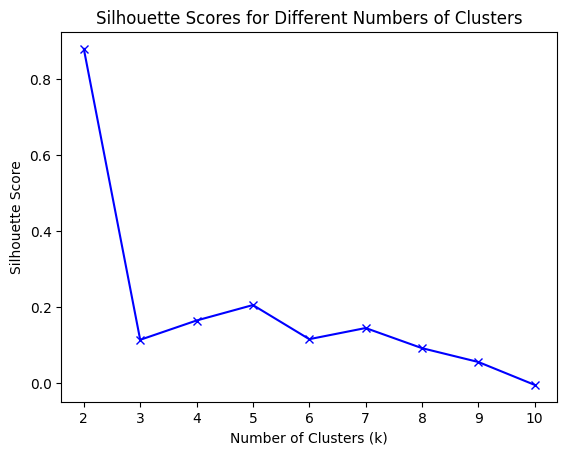

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# set up evaluator 
evaluator = ClusteringEvaluator()

# test between k=2 and 10 
k_list = range(2, 11)
silhouette_scores = []
for k in k_list:
  # set the KMeans stage of the pipe to hold each value of K 
  kmeans = pipe.getStages()[-1].setK(k).setSeed(1)  
  model = pipe.fit(combined_data)
  
  preds = model.transform(combined_data)

  # silhouette score each prediction set and append to scores list
  silhouette = evaluator.evaluate(preds)
  silhouette_scores.append(silhouette)

# plot the silhouette scores
plt.plot(k_list, silhouette_scores, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.show()
